In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from seisfwi.model import ElasticModel
from seisfwi.survey import Survey, Source, Receiver, GenericCable
from seisfwi.propagator import ElasticPropagator
from seisfwi.problem import ElasticFWI, WaveformL2Loss

from seisfwi.utils import wavelet, moment_tensor, plot_data, plot_sg, timer, plot_misfit, load_misfit, smooth2d
from seisfwi.utils import generate_ellipse_anomaly

## Working path

In [ ]:
path = './04-FWI-4D-DD'

os.makedirs(path, exist_ok=True)

### Parameters for elastic model

In [4]:
ox = 0.0
oz = 0.0
nx = 501
nz = 261
dx = 6.25
dz = 6.25

nt = 2000
dt = 0.002
f0 = 8.0
amp = 1e7

In [5]:
# True model for modeling obs data
vp = np.load('../models/Marmousi2/Marmousi-Vp-13601x2801-1.25m.npy').T
vs = np.load('../models/Marmousi2/Marmousi-Vs-13601x2801-1.25m.npy').T
rho = np.load('../models/Marmousi2/Marmousi-Rho-13601x2801-1.25m.npy').T

# cut the model
vp = vp[200:1505:5, 3000:5505:5].astype(np.float32)
vs = vs[200:1505:5, 3000:5505:5].astype(np.float32)
rho = rho[200:1505:5, 3000:5505:5].astype(np.float32)

(261, 501)


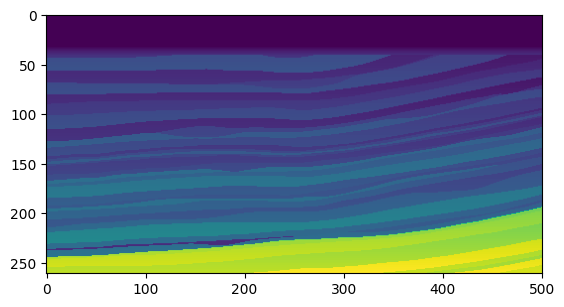

In [6]:
print(vp.shape)
plt.imshow(vp)

### Generate anomaly

In [7]:
# Define anomaly parameters
center_x = 1565
center_z = 950
major_axis = 400
minor_axis = 100
vp_amp  = -200
vs_amp  = 30
rho_amp = -60

# Generate anomaly
vp_co2 = generate_ellipse_anomaly(vp, dx,center_x, center_z, major_axis, minor_axis, vp_amp)
vs_co2 = generate_ellipse_anomaly(vp, dx,center_x, center_z, major_axis, minor_axis, vs_amp)
rho_co2 = generate_ellipse_anomaly(vp, dx,center_x, center_z, major_axis, minor_axis, rho_amp)

vp_ml = vp + vp_co2
vs_ml = vs + vs_co2
rho_ml = rho + rho_co2

In [8]:
# Create a elastic model object
model_bl = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp, vs = vs, rho = rho, free_surface=True, nabc=20)

model_bl

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1500.00 -  2619.12 m/s   , requires_grad = False, constrain bound: None - None
  Model vs  :     0.00 -  1149.73 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  1010.00 -  2258.91 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =   6.25, dz =   6.25 m
  Model dims: nx =    501, nz =    261
  Model size: 392283
  Free surface: True
  Absorbing layers: 20

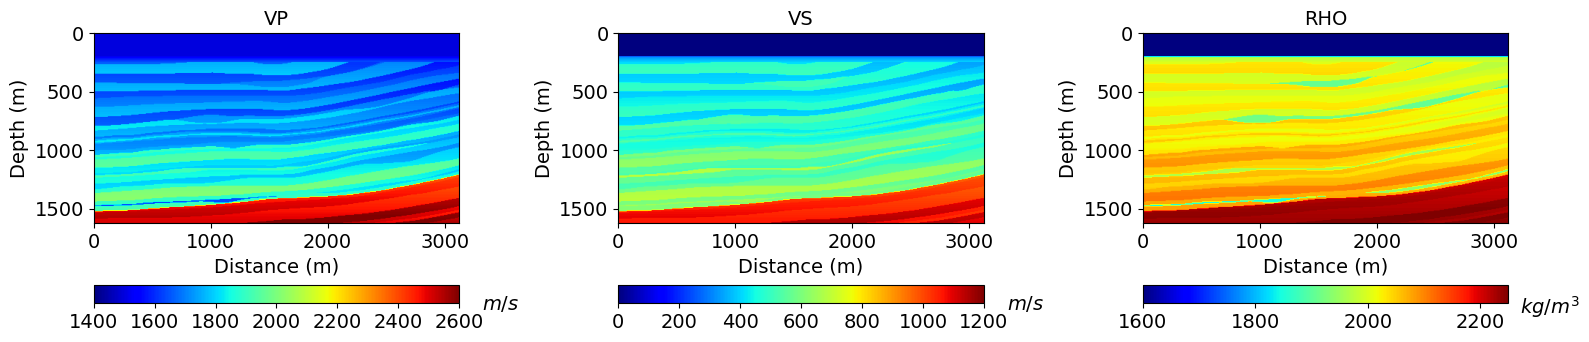

In [9]:
cmap_range={'vp': (1400, 2600), 'vs': (0, 1200), 'rho': (1600, 2250)}

model_bl.plot(cmap_range = cmap_range)

In [10]:
# Create a elastic model object
model_ml = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp_ml, vs = vs_ml, rho = rho_ml, free_surface=True, nabc=20)

model_ml

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1500.00 -  2619.12 m/s   , requires_grad = False, constrain bound: None - None
  Model vs  :     0.00 -  1149.73 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  1010.00 -  2258.91 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =   6.25, dz =   6.25 m
  Model dims: nx =    501, nz =    261
  Model size: 392283
  Free surface: True
  Absorbing layers: 20

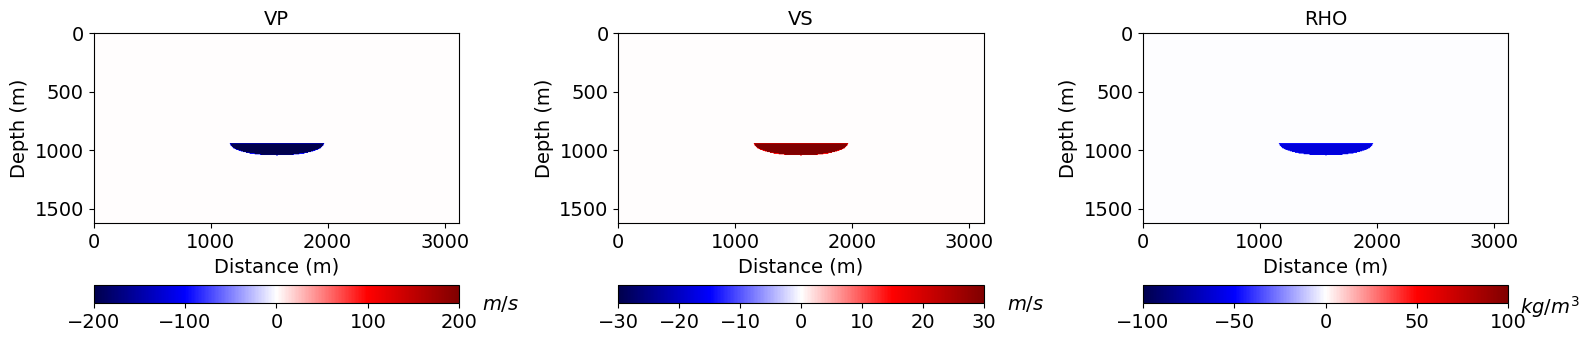

In [11]:
cmap_range_co2 = {'vp': (-200, 200), 'vs': (-30, 30), 'rho': (-100, 100)}

(model_ml - model_bl).plot(cmap_range = cmap_range_co2, cmap='seismic', save_path = f'{path}/change-CO2.png')

### Seismic Source 

In [12]:
# Create a seismic sources
source = Source(nt = nt, dt = dt, f0 = f0)

# Create wavelet
wvlt = wavelet(nt, dt, f0) * amp

# # Set source attributes
for isrc in range(24):
    source.add_source([125 * isrc + 125, dx], wvlt, 'pr')

source

Seismic Source:
  Source wavelet: 2000 samples at 2.00 ms
  Source number : 24
  Source types  : ['pr']
  Source x range: 125.00 - 3000.00 m
  Source z range:   6.25 -   6.25 m

### Set Receiver, Survey, and Modeling

In [13]:
# set trajectory
traj = np.array([[1500, 0.0, 30.0],[1500, 0.0, 500.0], [1500, 0.0, 1000.0],[1550, 0.0, 1100.0], [1650, 0.0, 1200.0], [1800, 0.0, 1300.0], [2000, 0.0, 1400.0]])

# set the cable
chann_len = 10.0
chann_num = 165
gauge_len = 10.0

cable = GenericCable(traj, chann_len, chann_num, gauge_len)
cable

Last channel length must be between 5.0 and 1622.1091166354774 m, it is 1655.0 m
Change the channel number to 162 to make sure the last channel ends at the end of the cable


DAS Cable Information: 
  Cable total length: 1627.11 m 
  Channel coverage: 5.00 - 1625.00 m 
  Channel interval: 10.00 m 
  Channel number: 162 
  Gauge length: 10.00 m 
  Max channel length error: 0.2676 m 
  Max  gauge  length error: 0.0595 m 


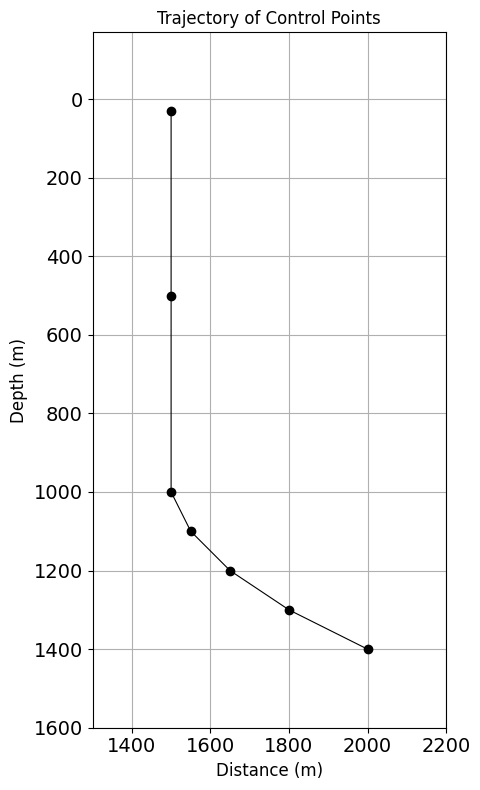

In [14]:
# plot provided trajectory
cable.plot_traj()

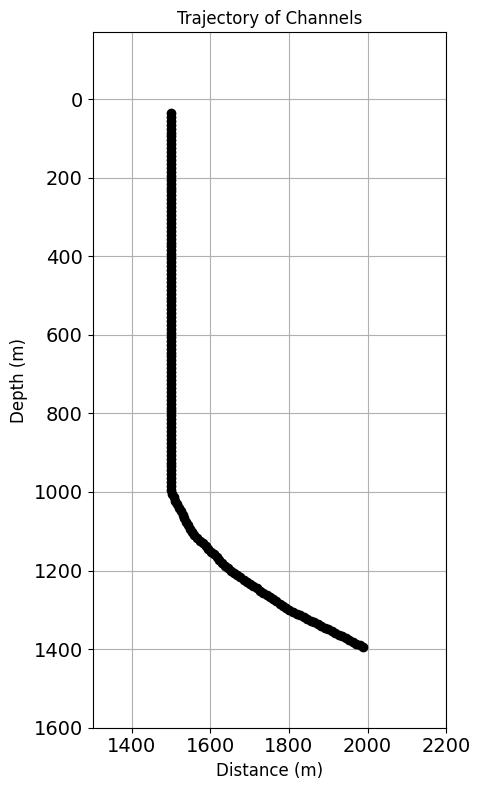

In [15]:
# plot channel location
cable.plot_channel()

In [16]:
# Create a set of seismic receiver
das = Receiver(nt = nt, dt = dt)

das.add_cable(cable)

  DAS cable is added to the survey with 163 unique receivers


In [17]:
# Note: for DAS modeling, we have to set interpolation to be True
survey = Survey(source=source, receiver=das, device='cuda', gpu_num=4, reciprocity=False, simultaneous=False, interpolation=True)

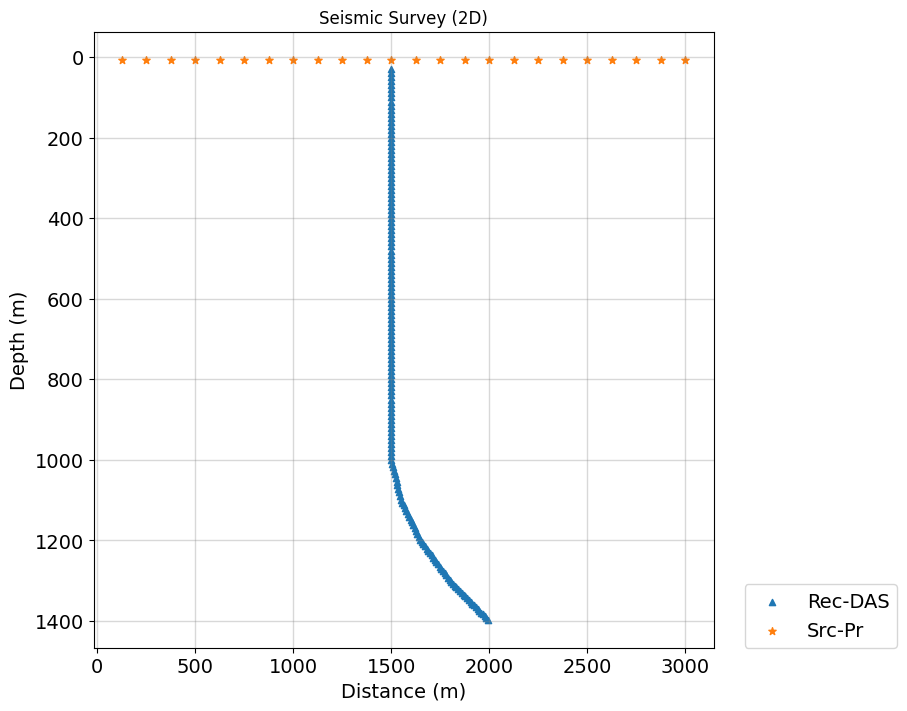

In [18]:
survey.plot()

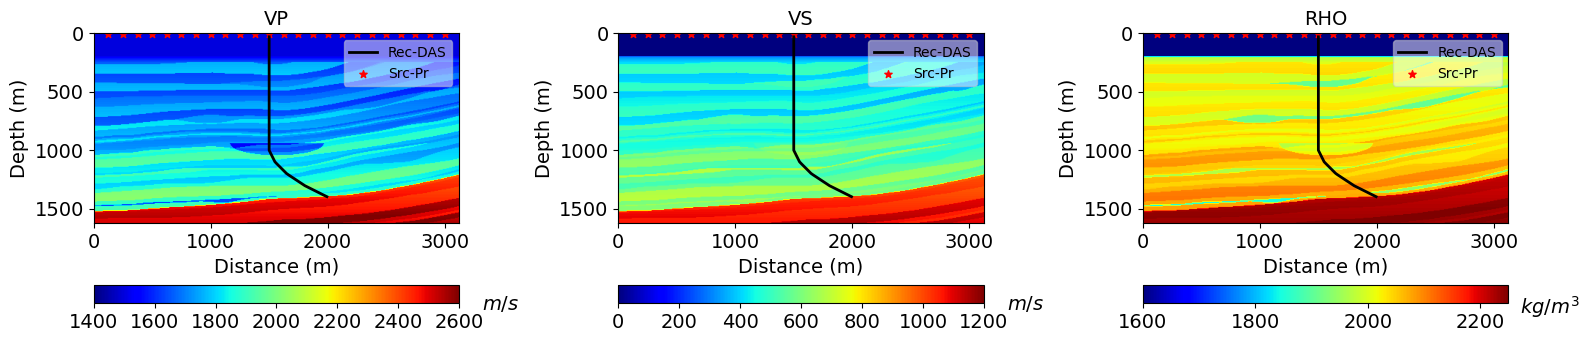

In [19]:
model_ml.plot(survey, cmap_range=cmap_range, save_path= f'{path}/marmousi-co2-survey.png')

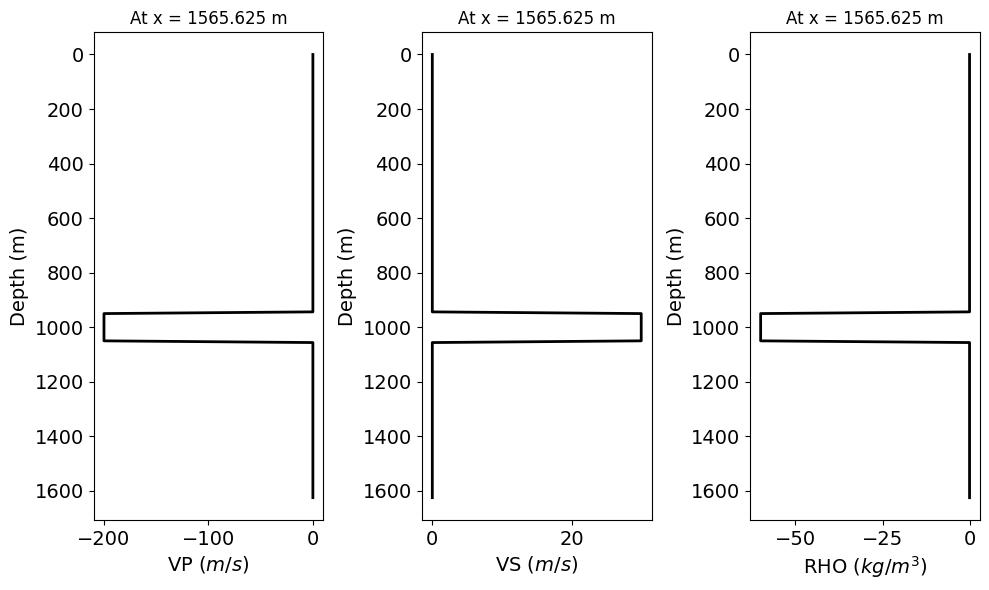

In [20]:
(model_ml - model_bl).plot_well_log()

In [21]:
F = ElasticPropagator(model_bl, survey)

Survey analysis completed: legal survey


In [22]:
dobs_bl = F(model_bl)
dobs_ml = F(model_ml)

/sep/haipeng/miniconda3/envs/pytorch/lib/python3.9/site-packages/deepwave/common.py:399: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 8.0, a minimum velocity of 0.0, and a grid cell spacing of 6.25, there are only 0.0.
  warnings.warn("At least six grid cells per wavelength is "


### Check DAS data

In [23]:
# #  DAS data
# dobs_bl.plot(shotid=2, comp=['das'], clip=98)
# dobs_ml.plot(shotid=2, comp=['das'], clip=98)

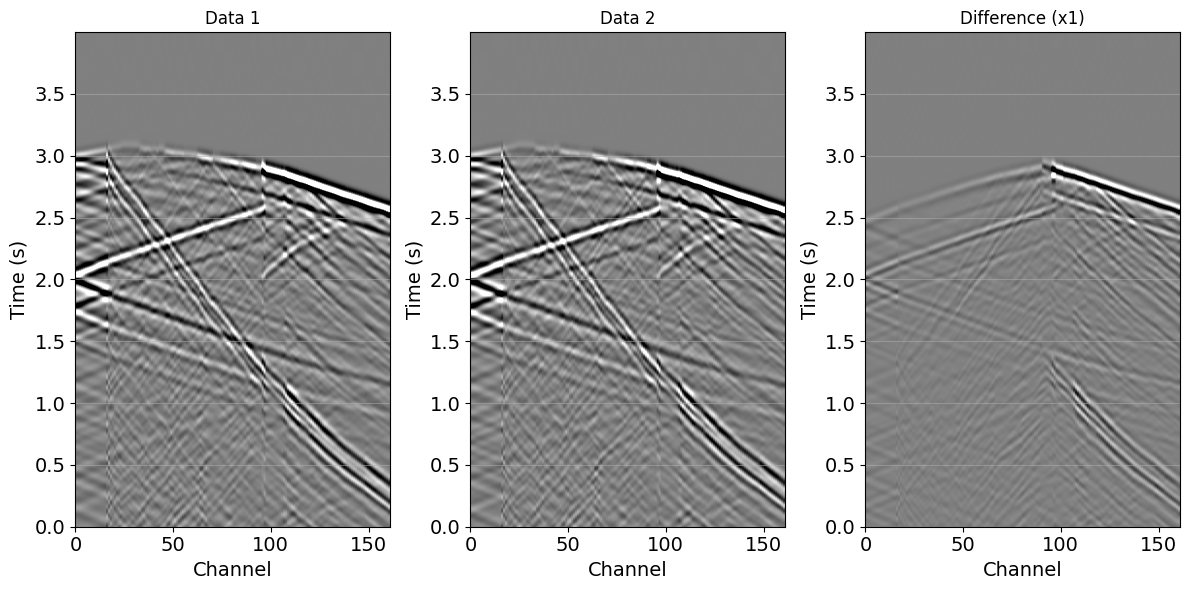

In [24]:
dobs_bl.plot_compare(dobs_ml, shotid=1, comp='das', clip=99., ratio=1)

In [25]:
# set fwi model
# Initial model for inversion

model_fwi_bl = ElasticModel.from_file('./02-FWI-DAS/model_fwi2.npz')

# MUST BE very careful here!!
vp_int = model_fwi_bl.get_model('vp')
vs_int = model_fwi_bl.get_model('vs')
rho_int = model_fwi_bl.get_model('rho')

nmask = 40

# set the gradient mask to exclude the water layers
grad_mask = np.ones((nz, nx))
grad_mask[:nmask,:] = 0.0
# grad_mask[nwater:nwater+10, :] = (np.repeat(np.linspace(0, 1, 10), nx)).reshape(10, nx)

Model loaded from file: ./02-FWI-DAS/model_fwi2.npz


### Prepare the double difference data

In [26]:
model_fwi_bl = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp_int, vs = vs_int, rho = rho_int, free_surface=False, nabc=20)

# model the syn data of the baseline model
dsyn_bl = F(model_fwi_bl)

In [27]:
dobs_ml.data['das'] = dobs_ml.data['das'] - dobs_bl.data['das'] + dsyn_bl.data['das']

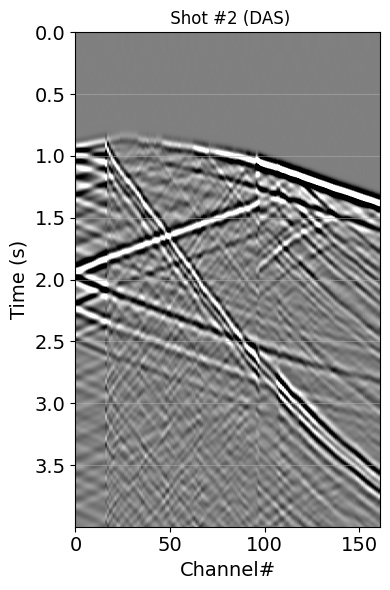

In [28]:
dobs_ml.plot(shotid=2, comp=['das'], clip=98)

In [29]:
model_fwi = ElasticModel(ox, oz, dx, dz, nx, nz,
                     vp = vp_int, 
                     vs = vs_int, 
                     rho = rho_int, 
                     vp_grad = True, 
                     vs_grad = True,
                     rho_grad = True,
                     vp_bound = [1200, 3000],
                     vs_bound = [0, 1300],
                     rho_bound = [900, 2500],
                     free_surface=False, 
                     nabc=20,
                     mask = grad_mask)

model_int = ElasticModel.clone(model_fwi)

model_fwi

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1500.00 -  2611.19 m/s   , requires_grad = True, constrain bound: 1200 - 3000
  Model vs  :     0.00 -  1143.23 m/s   , requires_grad = True, constrain bound: -1e-07 - 1300
  Model rho :  1010.00 -  2386.26 kg/m^3, requires_grad = True, constrain bound: 900 - 2500
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =   6.25, dz =   6.25 m
  Model dims: nx =    501, nz =    261
  Model size: 392283
  Free surface: False
  Absorbing layers: 20

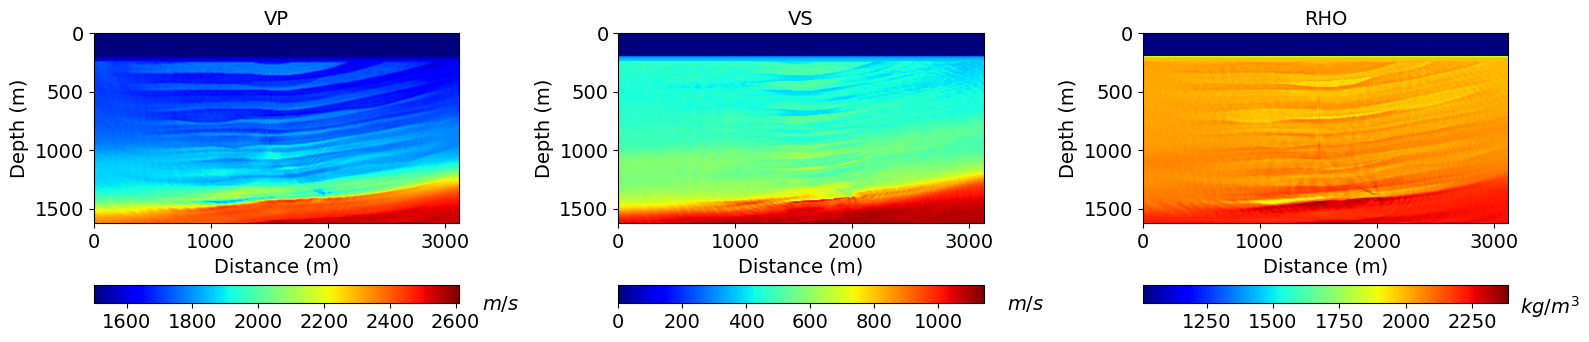

In [30]:
model_fwi.plot()

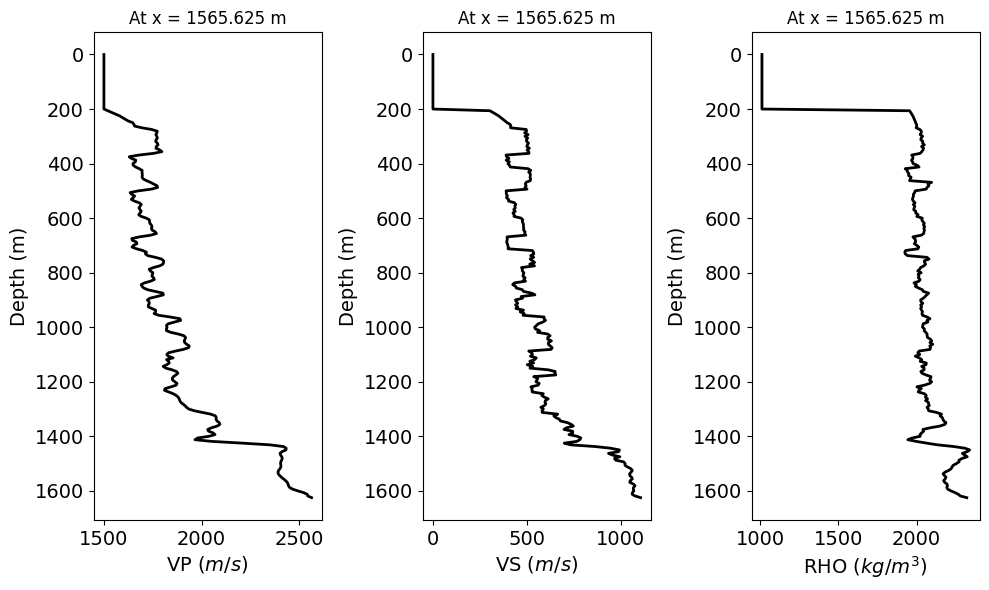

In [31]:
model_fwi.plot_well_log()

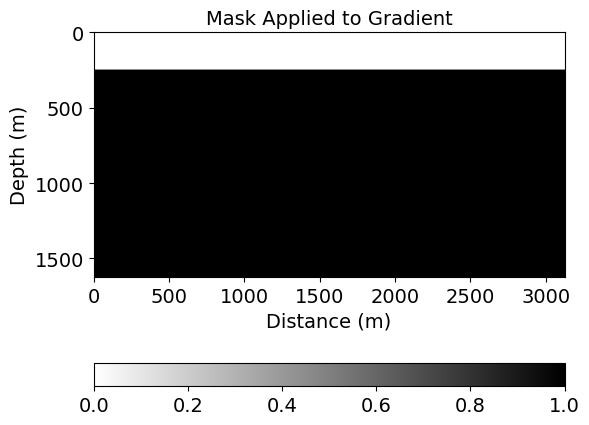

In [32]:
model_fwi.plot_mask()

In [33]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_fwi.parameters(), 
                  lr = 1.0, 
                  max_iter = 20, 
                  tolerance_change = 1e-4, 
                  history_size = 5,
                  line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'das': 1.0}

In [34]:
fwi = ElasticFWI(F, model_fwi, optimizer, misfit, dobs_ml, weight)

In [35]:
fwi(nshot_per_gpu_per_batch = 6, max_iter=2, grad_scale = 20.0, grad_interval=2)

FWI: evaluating initial model ...
**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :         20
***********************************************************

   Niter           fk                ngrad          max grad
     1       1.734889e+04                1         2.61e-01
     1       1.734747e+04                1         2.61e-01
     1       1.733935e+04                1         2.61e-01
     1       1.729092e+04                1         2.61e-01
     1       1.678410e+04                1         2.61e-01
     1       1.356020e+04                1         2.61e-01
     2       1.262490e+04                7         2.98e-01
     3       1.198862e+04                8         2.57e-01
     4       1.089332e+04                9         2.48e-01
     5       9.012883e+03               10        

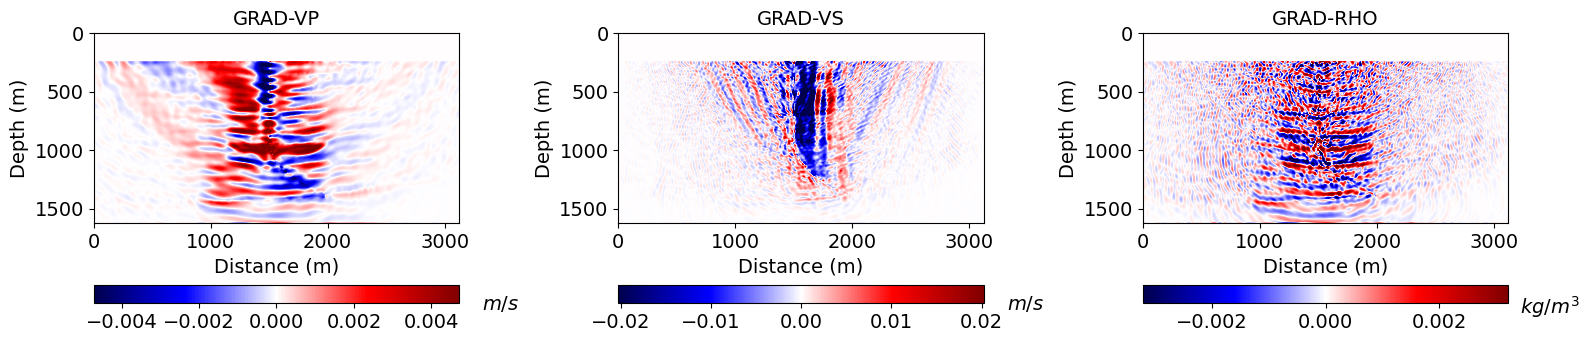

In [59]:
model_fwi.plot(grad=True, cmap='seismic', clip=99.)

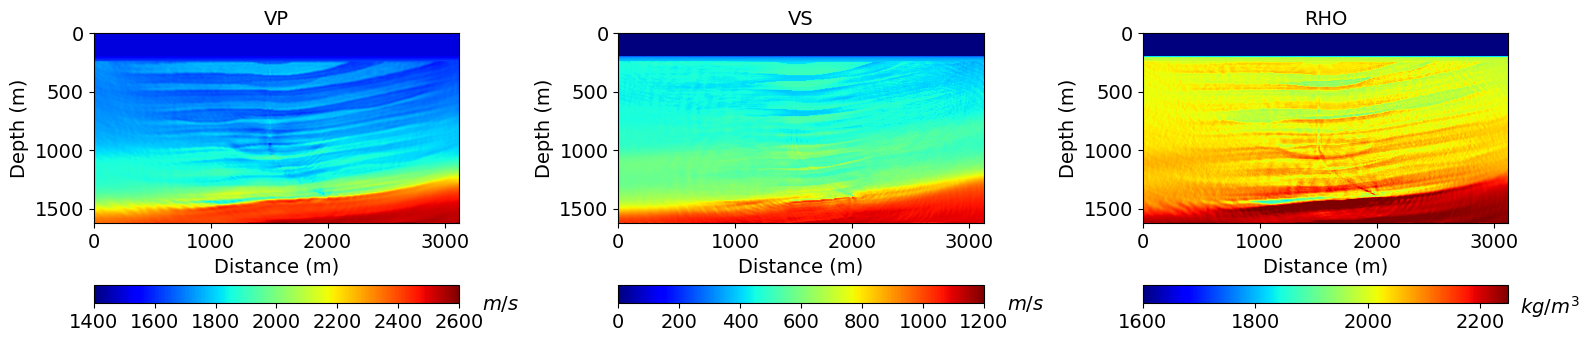

In [60]:
model_fwi.plot(cmap_range=cmap_range, save_path=f'{path}/marmousi-fwi-4D-DD.png')

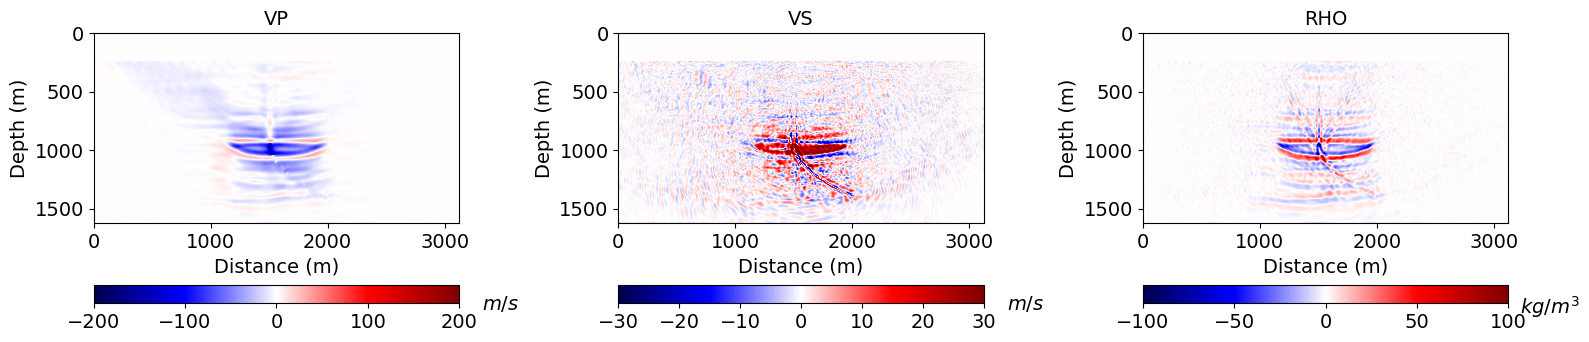

In [61]:
(model_fwi- model_int).plot(cmap_range = cmap_range_co2, cmap='seismic', save_path = f'{path}/change-CO2-FWI.png')

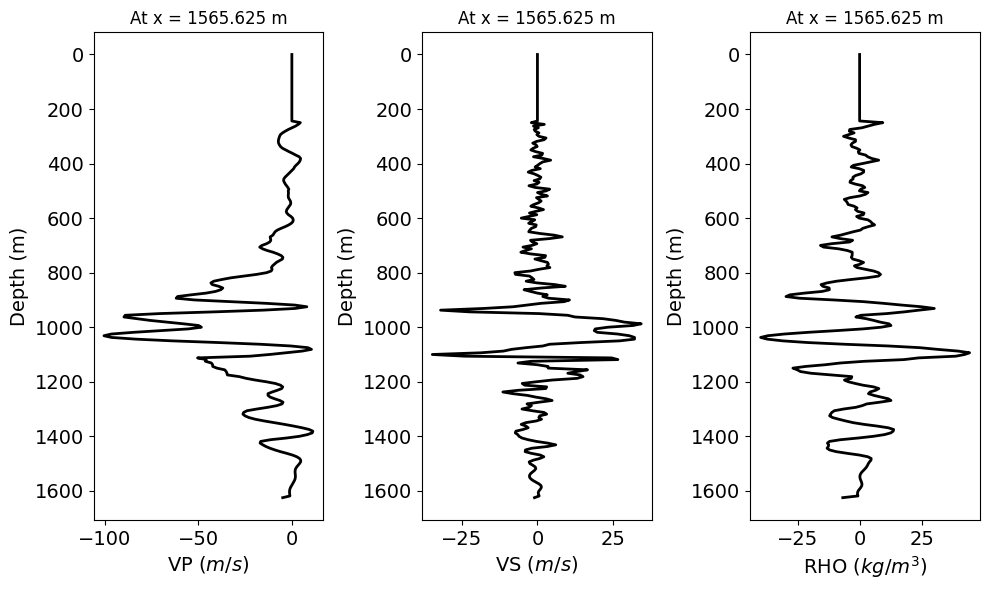

In [62]:
(model_fwi- model_int).plot_well_log()

In [63]:
model_bl.save(f'{path}/model_bl')
model_ml.save(f'{path}/model_ml')
model_int.save(f'{path}/model_int')
model_fwi.save(f'{path}/model_fwi1')

In [64]:
xxxxx

NameError: name 'xxxxx' is not defined

### Next frequency band

In [41]:
f0 = 16.0

# Create a seismic sources
source2 = Source(nt = nt, dt = dt, f0 = f0)

# Create wavelet
wvlt = wavelet(nt, dt, f0) * amp

# # Set source attributes
for isrc in range(24):
    source2.add_source([125 * isrc + 125, dx], wvlt, 'pr')

source2

Seismic Source:
  Source wavelet: 2000 samples at 2.00 ms
  Source number : 24
  Source types  : ['pr']
  Source x range: 125.00 - 3000.00 m
  Source z range:   6.25 -   6.25 m

In [42]:
# Note: for DAS modeling, we have to set interpolation to be True
# Here, I use false for speed purposes
survey2 = Survey(source=source2, receiver=das, device='cuda', gpu_num=4, reciprocity=False, simultaneous=False, interpolation=False)

In [43]:
F2 = ElasticPropagator(model_ml, survey2)

Survey analysis completed: legal survey


In [44]:
dobs2_bl = F2(model_bl)
dobs2_ml = F2(model_ml)

/sep/haipeng/miniconda3/envs/pytorch/lib/python3.9/site-packages/deepwave/common.py:399: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 16.0, a minimum velocity of 0.0, and a grid cell spacing of 6.25, there are only 0.0.
  warnings.warn("At least six grid cells per wavelength is "


In [45]:
model_fwi_bl2 = ElasticModel(ox, oz, dx, dz, nx, nz, vp = model_fwi.get_model('vp'), vs = model_fwi.get_model('vs'), rho = model_fwi.get_model('rho'), free_surface=False, nabc=20)

# model the syn data of the baseline model
dsyn2_bl = F2(model_fwi_bl2)

In [46]:
dobs2_ml.data['das'] = dobs2_ml.data['das'] - dobs2_bl.data['das'] + dsyn2_bl.data['das']

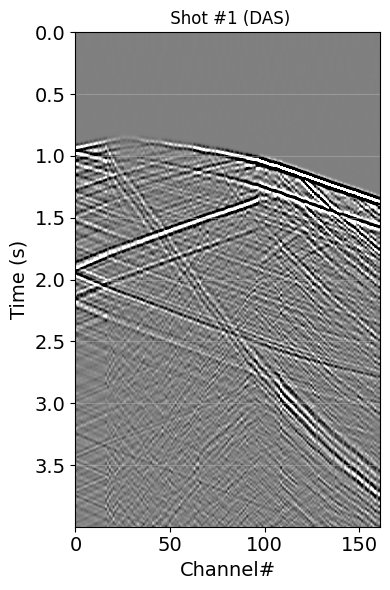

In [47]:
#  Vz data
dobs2_ml.plot(shotid=1, comp=['das'], clip=98)

In [48]:
model_fwi2 = ElasticModel(ox, oz, dx, dz, nx, nz,
                     vp = model_fwi.get_model('vp'), 
                     vs = model_fwi.get_model('vs'), 
                     rho = model_fwi.get_model('rho'), 
                     vp_grad = True, 
                     vs_grad = True,
                     rho_grad = True,
                     vp_bound = [1200, 3000],
                     vs_bound = [0, 1300],
                     rho_bound = [900, 2500],
                     free_surface=False, 
                     nabc=20,
                     mask = grad_mask)

model_int2 = ElasticModel.clone(model_fwi2)

model_fwi2

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1500.00 -  2612.22 m/s   , requires_grad = True, constrain bound: 1200 - 3000
  Model vs  :     0.00 -  1142.86 m/s   , requires_grad = True, constrain bound: -1e-07 - 1300
  Model rho :  1010.00 -  2374.43 kg/m^3, requires_grad = True, constrain bound: 900 - 2500
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =   6.25, dz =   6.25 m
  Model dims: nx =    501, nz =    261
  Model size: 392283
  Free surface: False
  Absorbing layers: 20

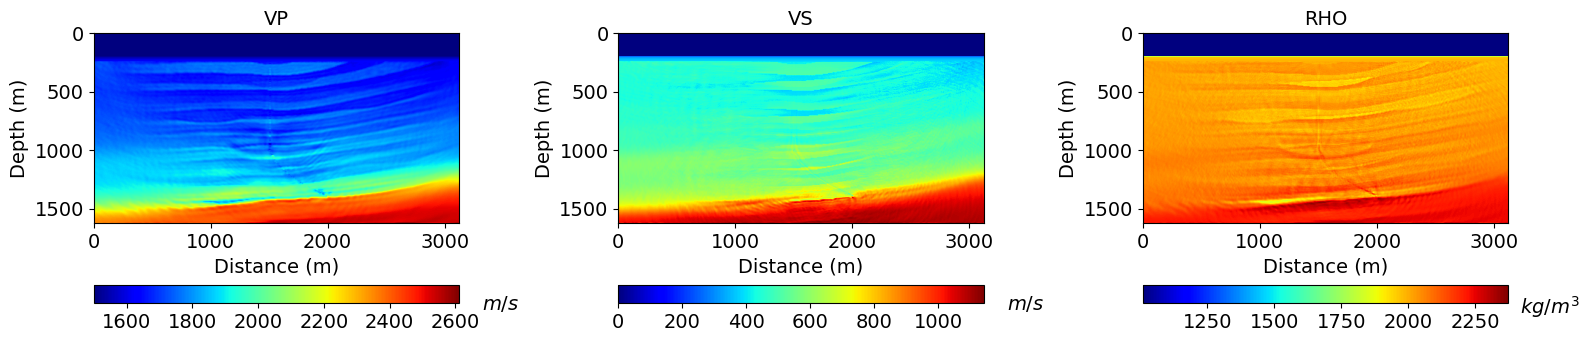

In [49]:
model_fwi2.plot()

In [50]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_fwi2.parameters(), 
                  lr = 1.0, 
                  max_iter = 20, 
                  tolerance_change = 1e-4, 
                  history_size = 5,
                  line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'das': 1.0}

In [51]:
fwi2 = ElasticFWI(F2, model_fwi2, optimizer, misfit, dobs2_ml, weight)

In [52]:
fwi2(nshot_per_gpu_per_batch = 4, max_iter=2, grad_scale = 20.0, grad_interval=2)

FWI: evaluating initial model ...
**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :         20
***********************************************************

   Niter           fk                ngrad          max grad
     1       2.771329e+04                1         5.89e-01
     1       2.771220e+04                1         5.89e-01
     1       2.770299e+04                1         5.89e-01
     1       2.762018e+04                1         5.89e-01
     1       2.722211e+04                1         5.88e-01
     2       2.453575e+04                6         6.15e-01
     3       2.373100e+04                7         6.22e-01
     4       1.952441e+04                8         6.34e-01
     5       1.706308e+04                9         5.99e-01
     6       1.674376e+04               10        

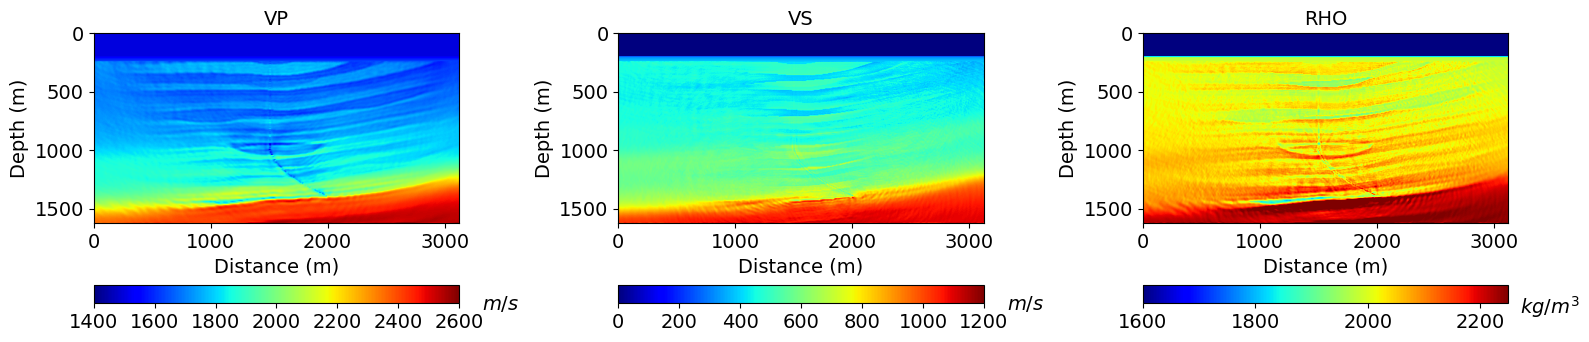

In [53]:
model_fwi2.plot(cmap_range=cmap_range, save_path=f'{path}/marmousi-fwi-4D-band2.png')

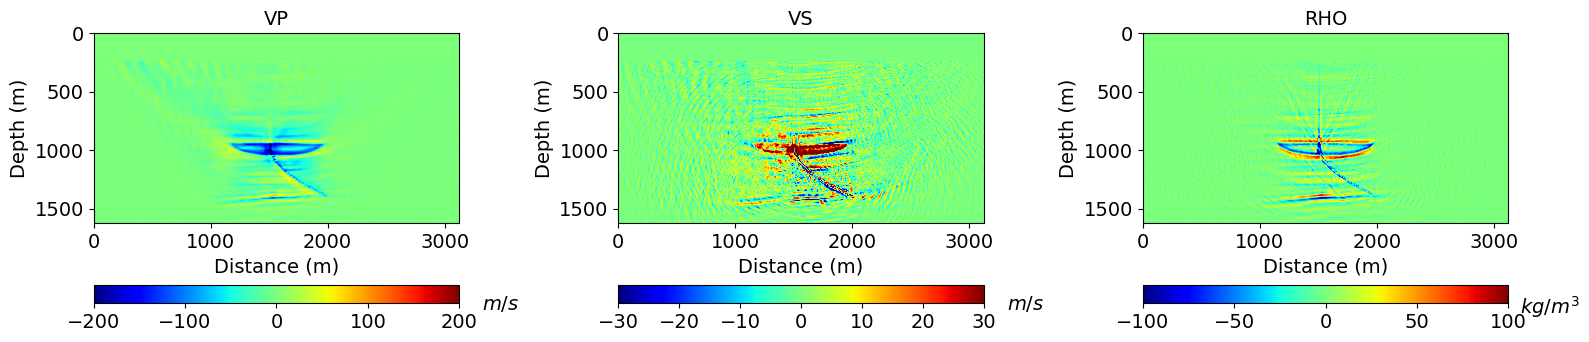

In [54]:
(model_fwi2- model_int).plot(cmap_range= cmap_range_co2, cmap='jet', clip=99)

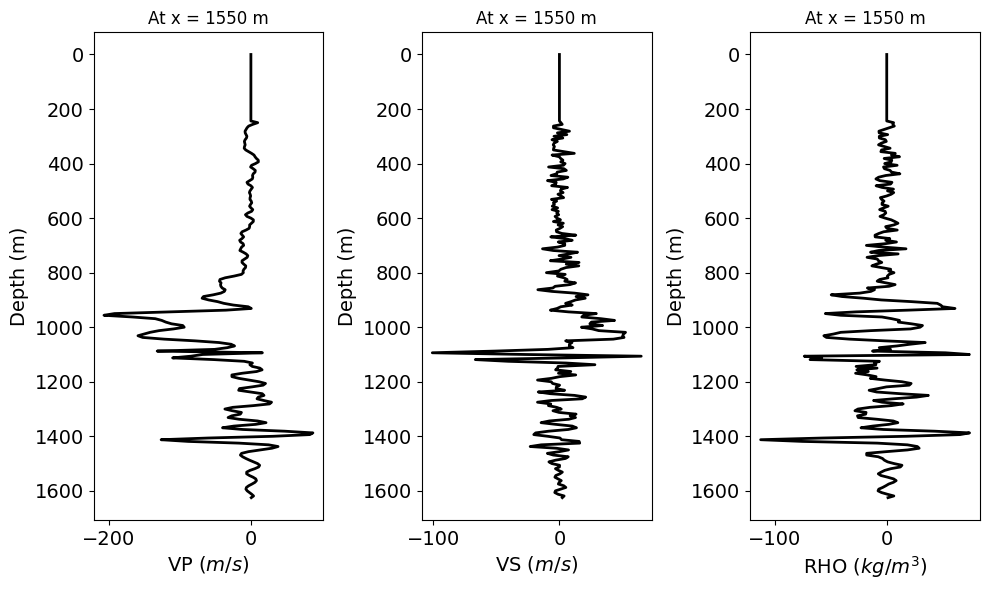

In [55]:
(model_fwi2- model_int).plot_well_log(x=1550)

In [56]:
model_bl.save(f'{path}/model_bl')
model_ml.save(f'{path}/model_ml')
model_int.save(f'{path}/model_int')
model_fwi.save(f'{path}/model_fwi1')
model_fwi2.save(f'{path}/model_fwi2')

In [57]:
vp_true = model_ml.get_model('vp')[:,nx//2]
vs_true = model_ml.get_model('vs')[:,nx//2]
rho_true = model_ml.get_model('rho')[:,nx//2]

vp_init = model_int.get_model('vp')[:,nx//2]
vs_init = model_int.get_model('vs')[:,nx//2]
rho_init = model_int.get_model('rho')[:,nx//2]

vp_fwi = model_fwi2.get_model('vp')[:,nx//2]
vs_fwi = model_fwi2.get_model('vs')[:,nx//2]
rho_fwi = model_fwi2.get_model('rho')[:,nx//2]

vp = [vp_true, vp_init, vp_fwi]
vs = [vs_true, vs_init, vs_fwi]
rho = [rho_true, rho_init, rho_fwi]

depth = model_ml.z

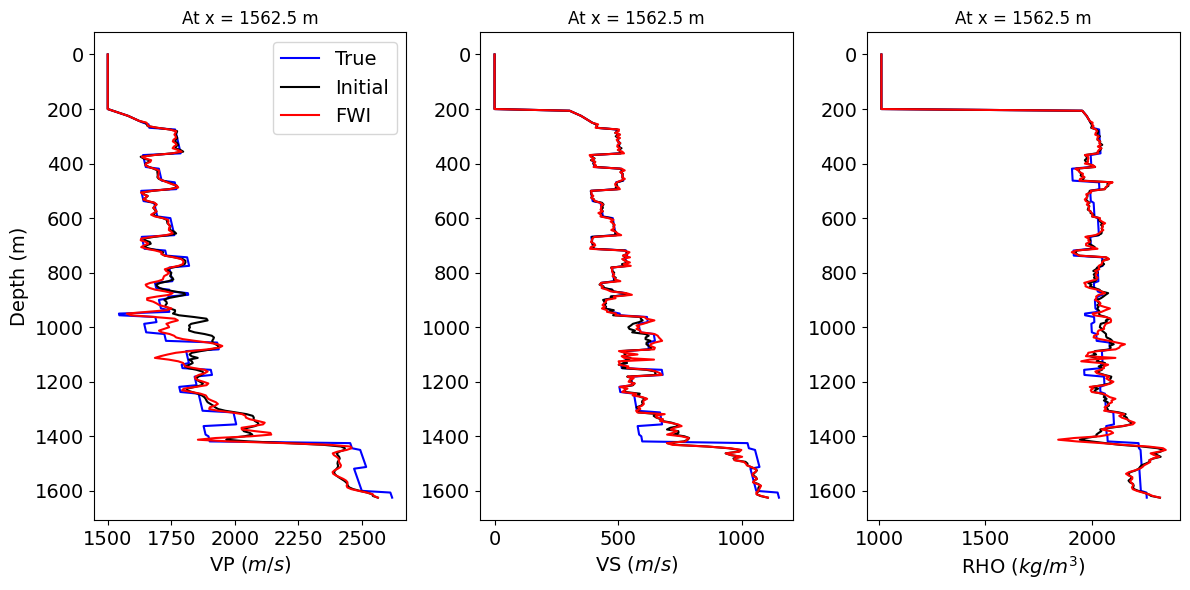

In [58]:
# set the default plot parameters


fontsize = 14
plt.rcParams.update(
    {
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,
        "figure.titlesize": fontsize,
    }
)

units = {
    "vp": "m/s",
    "vs": "m/s",
    "rho": "kg/m^3",
}

x = nx//2 * dx

pars = ['vp', 'vs', 'rho']

fig = plt.figure(figsize=(12, 6))
for i, par in enumerate([vp, vs, rho]):
    ax = fig.add_subplot(1,3,i+1)
    plt.plot(par[0], depth, 'b-', linewidth = 1.5, label='True')
    plt.plot(par[1], depth, 'k-', linewidth = 1.5, label='Initial')
    plt.plot(par[2], depth, 'r-', linewidth = 1.5, label='FWI')
    plt.xlabel(pars[i].upper() + f' (${units[pars[i]]}$)')

    if i==0:
        plt.ylabel("Depth (m)")
    plt.gca().invert_yaxis()
    plt.title(f'At x = {x} m')
    
    if i == 0:
        plt.legend(loc='best')

plt.tight_layout()

plt.savefig(f'{path}/marmousi-compare-well.png', dpi=300, bbox_inches='tight')

plt.show()